In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

In [3]:
import tools
from typing import List, Tuple

In [27]:
df = pd.read_csv("./data/UNRATE.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = ["UNRATE"]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

UNRATE    float64
dtype: object


,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [38]:
P = NUM_TIME_STEPS = 6
D = 1
Q = None
NUM_INPUTS = 1
NUM_OUTPUTS = 1

In [39]:
diff = df.diff()
slp = tools.gen_slp_sequential(diff, num_time_steps=P)

Failed time step ignored: 846
Failed time step ignored: 847
Failed time step ignored: 848
Failed time step ignored: 849
Failed time step ignored: 850
Failed time step ignored: 851


In [35]:
X, y, ts = tools.format_instances(slp)

num_instances=846, num_inputs=1, num_outputs=1, num_time_steps=6


In [36]:
(X_train, y_train, ts_train,
X_val, y_val, ts_val,
X_test, y_test, ts_test) = tools.split_dataset(X, y, ts)

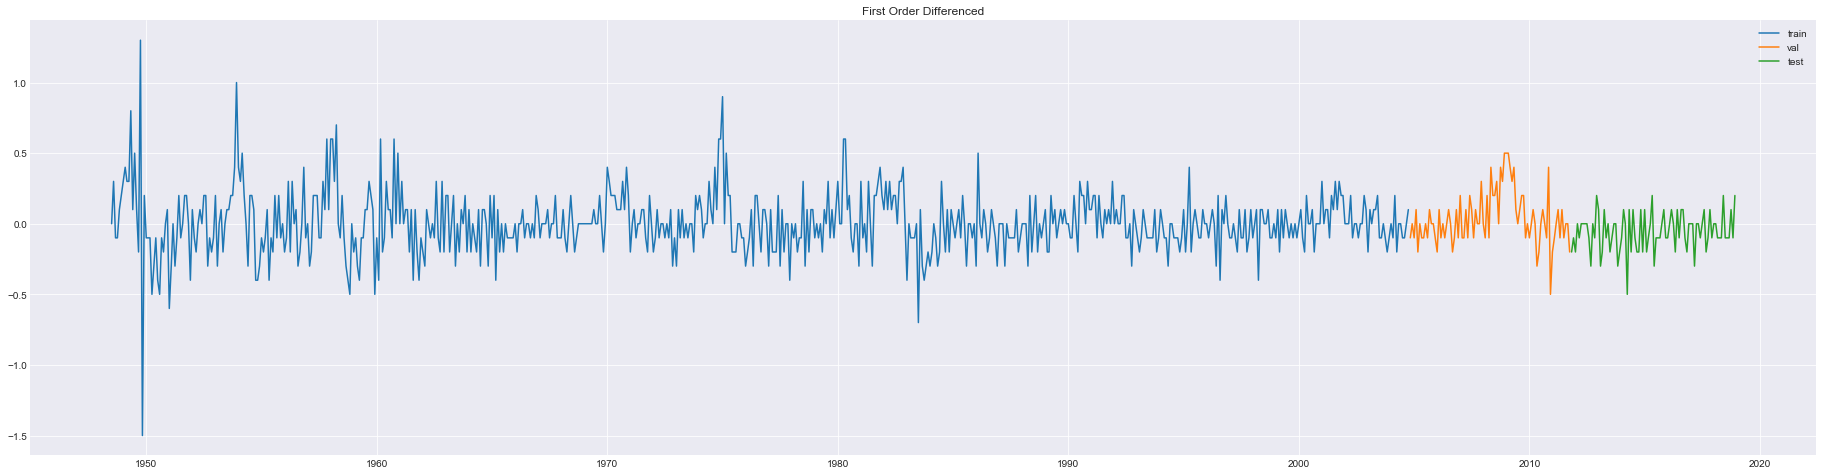

In [37]:
ax = plt.figure(figsize=(32,8))
plt.title("First Order Differenced")
plt.plot(ts_train, y_train[:, -1, :], label="train")
plt.plot(ts_val, y_val[:, -1, :], label="val")
plt.plot(ts_test, y_test[:, -1, :], label="test")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# ax = plt.figure(figsize=(32,8))
# plt.title("Log")
# plt.plot(ts_train, np.log(y_train[:, -1, :]), label="train")
# plt.plot(ts_val, np.log((y_val[:, -1, :])), label="val")
# plt.plot(ts_test, np.log(y_test[:, -1, :]), label="test")
# plt.legend()
# plt.grid(True)
# plt.show()

In [41]:
# Build LSTM Neural Net
with tf.name_scope("DATA_IO"):
    X = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS, NUM_INPUTS],
        name="FEATURE"
    )
    y = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS, NUM_OUTPUTS],
        name="LABEL"
    )